# REINFORCE in pytorch

Just like we did before for q-learning, this time we'll design a lasagne network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [2]:
%env THEANO_FLAGS = 'floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

env: THEANO_FLAGS='floatX=float32'


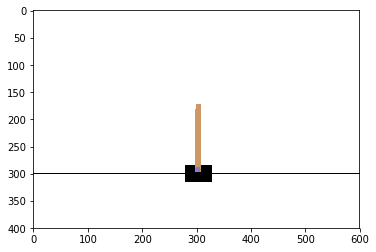

In [41]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [47]:
import torch
import torch.nn as nn

In [98]:
# Build a simple neural network that predicts policy logits. Keep it simple: CartPole isn't worth deep architectures.
agent = nn.Sequential()
agent.add_module("linear1",nn.Linear(state_dim,200))
agent.add_module("relu", nn.ReLU())
agent.add_module("linear2",nn.Linear(200,n_actions))

In [99]:
device = torch.device("cuda")
agent.to(device)
agent.device = device

#### Predict function

In [77]:
def predict_proba(agent,states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    s = torch.tensor(states, dtype=torch.float32, device=agent.device) 
    out = agent.forward(s)
    out = nn.functional.softmax(out, dim=1)
    out = out.detach().cpu().numpy()
    
    return out

In [78]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_proba(agent,test_states)
assert isinstance(
    test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (
    test_states.shape[0], n_actions), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1),
                   1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [100]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """

    # arrays to record session
    states, actions, rewards = [], [], []
    
    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = predict_proba(agent,np.array([s]))[0]

        a = np.random.choice(env.action_space.n, p=action_probas)

        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [101]:
# test it
states, actions, rewards = generate_session()

### Computing cumulative rewards

In [102]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    G = []
    G_t = 0
    for r in reversed(rewards):
        G_t  = r + gamma*G_t
        G.append(G_t)
    return list(reversed(G))

In [12]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Policy gradient is:

$$ \frac{\partial}{\partial \theta} V^{\pi} (s_0) = \int_s d(s) \int_a \frac{\partial \pi(a|s)}{\partial \theta} Q^{\pi}(s,a) \ dads  =  \int_s d(s) \int_a \pi(a|s) \frac{\partial \log{\pi(a|s)}}{\partial \theta} Q^{\pi}(s,a) \ dads ,$$

where 

$$ d(s) = \sum^{\infty}_{t=0} \gamma^t p(s_t=s|s_0,\pi) $$

Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [103]:
# Your code: define optimizers

def train_on_session(states, actions, rewards, gamma=0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    opt = torch.optim.Adam(agent.parameters())

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32, device=agent.device)
    cumulative_returns = get_cumulative_rewards(rewards, gamma)
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32, device=agent.device)

    # predict logits, probas and log-probas using an agent.
    logits = agent.forward(states)
    probas = nn.functional.softmax(logits, dim=1)
    logprobas = nn.functional.log_softmax(logits, dim=1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probas, logprobas]), \
        "please use compute using torch tensors and don't use predict_proba function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    logprobas_for_actions = logprobas[range(len(actions)),actions]

    # REINFORCE objective function
    J_hat = torch.mean(logprobas_for_actions*cumulative_returns)

    # regularize with entropy
    entropy_reg = -(probas*logprobas).sum(-1).mean()

    loss = - J_hat - 0.1 * entropy_reg

    # Gradient descent step
    loss.backward()
    opt.step()
    opt.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [104]:
for i in range(100):

    rewards = [train_on_session(*generate_session())
               for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward:31.330
mean reward:58.660
mean reward:54.190
mean reward:72.870
mean reward:88.670
mean reward:60.190
mean reward:119.460
mean reward:174.820
mean reward:158.250
mean reward:99.430
mean reward:106.500
mean reward:110.860
mean reward:105.610
mean reward:117.790
mean reward:102.350
mean reward:102.500
mean reward:122.900
mean reward:113.930
mean reward:124.820
mean reward:149.470
mean reward:200.600
mean reward:605.380
You Win!


### Video

In [105]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [106]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices